In [2]:
import os
from pathlib import Path
from typing import Optional

import fastmri
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from data_utils import *
from datasets import *
from fastmri.data.transforms import tensor_to_complex_np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torch.utils.data import DataLoader, TensorDataset

from model import *
from torch.optim import SGD, Adam, AdamW
from train_utils import *

ImportError: libcublasLt.so.11: failed to map segment from shared object

In [2]:
model_checkpoint = '/scratch_net/ken/mcrespo/proj_marina/logs/multivol_11_20/2024-11-21_12h41m22s/checkpoints/epoch_0499.pt'  # TODO: SET (OR LEAVE COMMENTED).
path_to_data = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/'


In [3]:
n_volumes= 1
n_slices= 2
with_mask= True  # NOTE: During inference phase, set to True.
acceleration= 4
vol_embedding_dim = 256
coil_embedding_dim = 128
center_frac= 0.15
embedding_dim = 256
sigma = 0.1

dataset = KCoordDataset(path_to_data, n_volumes=n_volumes, n_slices=n_slices, with_mask=with_mask, acceleration=acceleration, center_frac=center_frac)

model = Siren(coord_dim=3, vol_embedding_dim=vol_embedding_dim, coil_embedding_dim=coil_embedding_dim, hidden_dim=512, n_layers=8, out_dim=2)
# Load checkpoint.
model_state_dict = torch.load(model_checkpoint,  map_location=torch.device('cpu'))["model_state_dict"]
model.load_state_dict(model_state_dict)
print("Checkpoint loaded successfully.")

# Only embeddings are optimized.
for param in model.parameters():
    param.requires_grad = False


#####################################################################
# volume embedding
#####################################################################
embeddings_vol = torch.nn.Embedding(
    len(dataset.metadata), vol_embedding_dim
)
torch.nn.init.normal_(
    embeddings_vol.weight.data, 0.0, sigma
)

###################################################################
# Coil embeddings
########################################################
coil_sizes = []
for i in range(len(dataset.metadata)):
    _, n_coils, _, _ = dataset.metadata[i]["shape"]
    coil_sizes.append(n_coils)
    
total_n_coils = torch.cumsum(torch.tensor(coil_sizes), dim=0)[-1]

# Create the indexes to access the embedding coil table
start_idx = torch.tensor([0] + list(torch.cumsum(torch.tensor(coil_sizes), dim=0)[:-1]))

# Create the table of embeddings for the coils
embeddings_coil = torch.nn.Embedding(total_n_coils.item(), coil_embedding_dim)
torch.nn.init.normal_(
    embeddings_coil.weight.data, 0.0, sigma
)

model.eval()

Checkpoint loaded successfully.


/tmp/ipykernel_20938/1820171663.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_checkpoint,  map_location=torch.device('cpu'))["mode

Siren(
  (sine_layers): ModuleList(
    (0): SineLayer(
      (linear): Linear(in_features=444, out_features=512, bias=True)
    )
    (1-3): 3 x SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=896, out_features=512, bias=True)
    )
    (5-7): 3 x SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (output_layer): Linear(in_features=512, out_features=2, bias=True)
)

In [4]:
dataloader = DataLoader(
    dataset,
    batch_size=1_000,
    num_workers=0,
    shuffle=True,
)

vol_id = 0
shape = dataloader.dataset.metadata[vol_id]["shape"]
center_data = dataloader.dataset.metadata[vol_id]["center"]
left_idx, right_idx, center_vals = (
    center_data["left_idx"],
    center_data["right_idx"],
    center_data["vals"],
)
n_slices, n_coils, height, width = shape

volume_kspace = torch.zeros(
    (n_slices, n_coils, height, width, 2),
    dtype=torch.float32,
)
predicted_volume = volume_kspace.clone()

for batch_idx, (inputs,inputs_unnormalized,targets) in enumerate(dataloader):
    
    coords = inputs[:, 1:-1] # kx,ky,kz
    vol_ids = inputs[:,0].long()
    coil_ids = inputs[:,-1].long() # unnormalized coilID
    
    latent_vol = embeddings_vol(vol_ids)
    latent_coil = embeddings_coil(start_idx[vol_ids] + coil_ids)

    outputs = model(coords, latent_vol, latent_coil)
    
    predicted_volume[inputs_unnormalized[:,2], inputs_unnormalized[:,3], inputs_unnormalized[:,1], inputs_unnormalized[:,0]] = outputs
    volume_kspace[inputs_unnormalized[:,2], inputs_unnormalized[:,3], inputs_unnormalized[:,1], inputs_unnormalized[:,0]] = targets

(-0.5, 319.5, 319.5, -0.5)

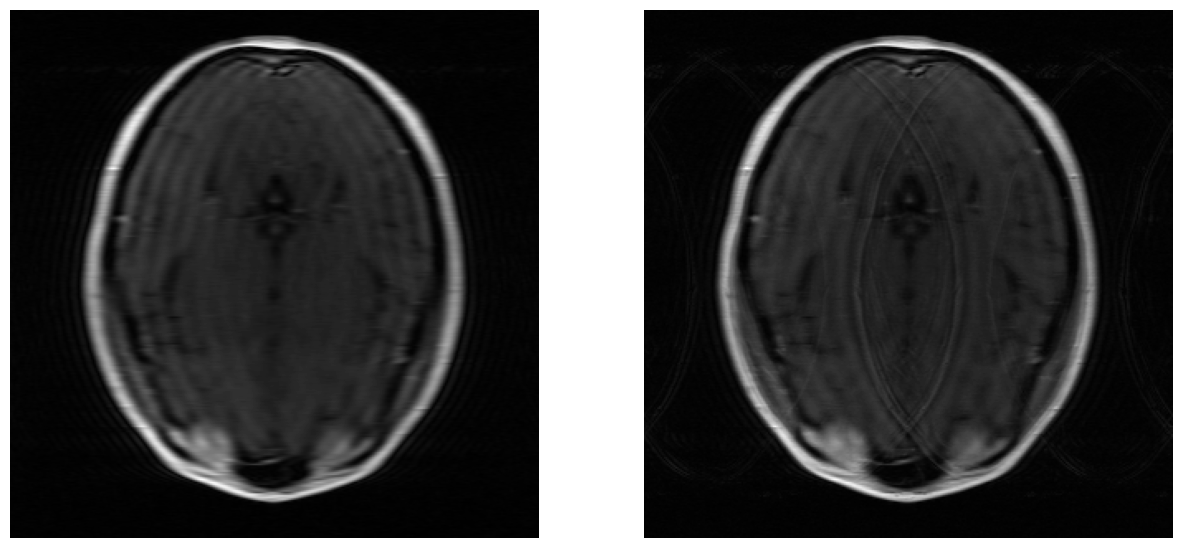

In [ ]:
gt_volume_kspace = (
    volume_kspace * dataloader.dataset.metadata[vol_id]["norm_cste"]
)
predicted_kspace = (predicted_volume * dataloader.dataset.metadata[vol_id]["norm_cste"])


predicted_kspace = tensor_to_complex_np(predicted_kspace.detach().cpu())
gt_volume_kspace = tensor_to_complex_np(gt_volume_kspace)


predicted_kspace[..., left_idx:right_idx] = center_vals
gt_volume_kspace[..., left_idx:right_idx] = center_vals

predicted_img = rss(inverse_fft2_shift(predicted_kspace))
gt_img = rss(inverse_fft2_shift(gt_volume_kspace))

eps = 1.e-45

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
# plt.imshow(np.log(np.abs(predicted_kspace[0]) + eps))
plt.imshow(np.abs(predicted_img[0]), cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.abs(gt_img[0]), cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(np.log(np.abs(gt_kspace[0]) + eps))
plt.axis('off')



Text(0.5, 1.0, 'model')

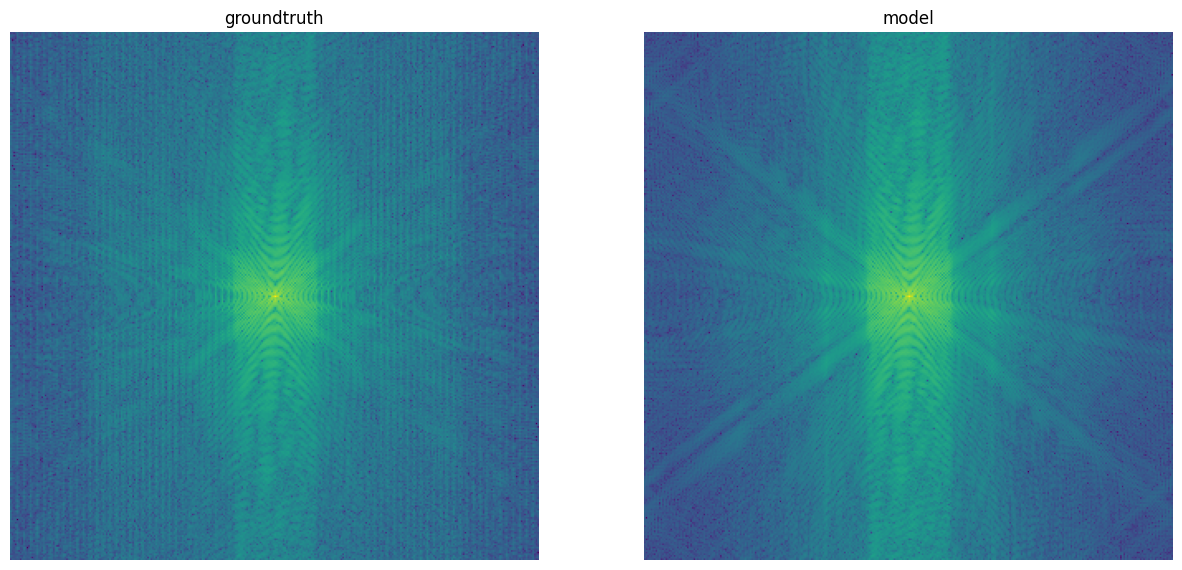

In [14]:
gt_modulus = np.abs(fft2_shift(gt_img))
predicted_modulus = np.abs(fft2_shift(predicted_img))


plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(np.log(gt_modulus[0] + eps))
plt.axis('off')
plt.title('groundtruth')
plt.subplot(1,2,2)
plt.imshow(np.log(predicted_modulus[0] + eps))
plt.axis('off')
plt.title('model')

In [1]:


plt.subplot(1, 2, 1)
plt.imshow(np.log(predicted_modulus / dataloader.dataset.metadata[vol_id]["norm_cste"]))
plt.colorbar()
plt.title("Kspace")
plt.subplot(1, 2, 2)
plt.hist(predicted_modulus.flatten(), log=True, bins=100)

NameError: name 'plt' is not defined

In [ ]:
dataset_fullysampled = KCoordDataset(path_to_data, n_volumes=n_volumes, n_slices=n_slices, with_mask=False, center_frac=center_frac)

dataloader_fullysampled = DataLoader(
    dataset,
    batch_size=1_000,
    num_workers=0,
    shuffle=True,
)


shape = dataloader.dataset.metadata[vol_id]["shape"]
center_data = dataloader.dataset.metadata[vol_id]["center"]
left_idx, right_idx, center_vals = (
    center_data["left_idx"],
    center_data["right_idx"],
    center_data["vals"],
)
n_slices, n_coils, height, width = shape

sampled_volume_kspace = torch.zeros(
    (n_slices, n_coils, height, width, 2),
    dtype=torch.float32,
)
sampled_predicted_volume = volume_kspace.clone()

for batch_idx, (inputs,inputs_unnormalized,targets) in enumerate(dataloader):
    
    coords = inputs[:, 1:-1] # kx,ky,kz
    vol_ids = inputs[:,0].long()
    coil_ids = inputs[:,-1].long() # unnormalized coilID
    
    latent_vol = embeddings_vol(vol_ids)
    latent_coil = embeddings_coil(start_idx[vol_ids] + coil_ids)

    outputs = model(coords, latent_vol, latent_coil)
    
    sampled_predicted_volume[inputs_unnormalized[:,2], inputs_unnormalized[:,3], inputs_unnormalized[:,1], inputs_unnormalized[:,0]] = outputs
    sampled_volume_kspace[inputs_unnormalized[:,2], inputs_unnormalized[:,3], inputs_unnormalized[:,1], inputs_unnormalized[:,0]] = targets
